# Installations

# Imports

In [2]:
import io
import os
import gc
%matplotlib inline
import matplotlib.pyplot as plt

# data management
import xarray as xr
import numpy as np
import pandas as pd

# Azure Connectivity
import getpass
import azure.storage.blob
from azure.storage.blob import BlobClient

# utilities
import time
import urllib.request
from datetime import datetime
import cftime
import urllib
        

# Code to Generate Average and Record Temperature
* For the specified number of years

### Function to create the empty Results xarray dataset 

In [3]:
def CreateDatasetForResults(filename, start_year, end_year, cmip=6):
    """
    A function that loads the CMIP data file and uses the xarray dataset for reference,
    creates and returns a new xarray with matching dimensions and coordinates but new, empty variables
    The variables of the xarray will be ['tasmaxavg', 'tasmaxrec'] or ['tasminavg', 'tasminrec']
    Similar three dimensions and the coordinates will be there [day: 365, lat: 720,  lon: 1440]
    Input Parameter:
    - filename : a CMIP source data file for createing the reference xarray dataset.
    - start_year : should be the integer value for the intended results date range start (e.g. 1950)
    - end_year : should be the integer value for the intended results date range end (e.g. 1959)
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6    
    Returns: an xarray dataset
    """
    ds_rec = None
    validations_passed = False
    data_type = ''
    
    # validations
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    else:
        validations_passed = True
    
    if validations_passed:
        # load the file
        based_on = xr.open_dataset(filename)
        
        var_minmax = list(based_on.data_vars.keys())[0]  # will be tasmax or tasmin
        
        #shape of the dataset
        day_time = based_on.dims.get('time')
        lat = based_on.dims.get('lat')
        lon = based_on.dims.get('lon')
                
        
        if var_minmax == 'tasmax':
            data_type = 'Average and record maximum temperature, based on tasmax'
            ds_variables = ['tasmaxavg', 'tasmaxrec']
            ds_data = {'tasmaxavg' : (['day','lat','lon'], np.empty((day_time, lat, lon))), 'tasmaxrec' : (['day','lat','lon'], np.empty((day_time, lat, lon)))}
        else:
            data_type = 'Average and record minimum temperature, based on tasmin'
            ds_variables = ['tasminavg', 'tasminrec']
            ds_data = {'tasminavg' : (['day','lat','lon'], np.empty((day_time, lat, lon))), 'tasminrec' : (['day','lat','lon'], np.empty((day_time, lat, lon)))}

        ds_rec = based_on.copy(deep = True)   
        ds_rec = ds_rec.rename_dims({'time':'day'})
        ds_rec = ds_rec.assign(ds_data)
        ds_rec = ds_rec.drop_vars(var_minmax)
        ds_rec = ds_rec.assign_coords({"day": xr.DataArray(np.arange(1,366), dims='day')})
        ds_rec = ds_rec.reset_coords('time', drop=True)
        
        n_years = (end_year - start_year) + 1
        
        new_attrs = {'Dataset' : 'Average temperature CMIP{}'.format(cmip),
                     'About dataset' : 'A dataset with average and record temparatures, across years',
                     'Original values' : var_minmax,
                     'Data variables' : ds_variables,
                     'Data description' : data_type,
                     'Range' : str(n_years) + ' years',
                     'Start year' : str(start_year),
                     'End year' : str(end_year),
                     'Years processed' : 0,
                     'Store as' : 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}'.format(var_minmax[-3:]
                                                                               ,cmip
                                                                               ,n_years
                                                                               ,start_year
                                                                               ,end_year)
                    }
        
        ds_rec.attrs = new_attrs
    
    return ds_rec
        


### Function to process each file at a time

In [4]:
def GenerateAverageOneFileAtATime(results, lat_indices, lon_indices, start_year, end_year
    , filename):
    """
    Takes one file at a time and updates the average, peak values in the existing 'results' dataset.
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The unit of temperature (Kelvin) is retained.
    Input Parameters:
    - results     : xarray dataset with average, record temperature for 365 days
    - lat_indices : applicable index values for latitudes. If None, will calculate for the complete grid
    - lon_indices : applicable index values for longitudes. If None, will calculate for the complete grid.
    - start_year  : start year of the range
    - end_year    : end year of the range
    - filename    : name of the .nc file to process
    Returns:  None. The input xarray dataframe 'results' is updated.
    """
    # load the file
    print(filename)
    xds = xr.open_dataset(filename)
    
    if not (lat_indices is None or lon_indices is None):
        # take applicabel subset of lat and lon
        xds = xds[dict(lat=lat_indices,lon=lon_indices)]
    
    # print("xds", xds)     ## For debugging
    
    # max or min
    var_minmax = list(xds.data_vars.keys())[0]  # will be tasmax or tasmin
        
    # note the variable names in the results dataset
    result_variables = results.attrs['Data variables']

    new_values = xds[var_minmax][:].to_numpy()

    n_years = results.attrs['Years processed']
    
    # if first year in the range
    if n_years == 0:
        results.update({result_variables[0] : (['day','lat','lon'], new_values)       # avg temperature
                        , result_variables[1] : (['day','lat','lon'], new_values)})   # record temperature        
    else:
        if var_minmax == "tasmin":        
            results.update({result_variables[1] : xr.ufuncs.minimum(new_values
                                                                    , results[result_variables[1]])})   # peak min temperature across years
        else:
            results.update({result_variables[1] : xr.ufuncs.maximum(new_values
                                                                    , results[result_variables[1]])})   # peak max temperature across years
        # for both max and min
        results.update({result_variables[0] : np.round((((results[result_variables[0]] * n_years) + new_values) / (n_years+1)),2)})  # avg across years
        results.update({result_variables[1] : np.round(results[result_variables[1]], 2)})  # round off only
        
    
    # in any case...
    n_years += 1
    results.attrs['Years processed'] = n_years


### Function to download a specified file

In [5]:
def download_file(sas_url, filename, overwrite_local_file, from_azure=False, print_msg=False):
    """
    Downloads the specified file from the internet -- and if specified, from Azure blob storage
    If asked to not overwrite, then first checks if the file is available locally and does not download again in that case.
    - sas_url   : url complete with sas token
    - filename  : name of the downloaded file
    - overwrite_local_file : if True, will overwrite, else, if already available locally, will not download again.
    - from_azure: default False. if True, will download from the azure blob storage
    Returns:  None
    """
    if print_msg:
        print("downloading {}, from_azure {}".format(filename, from_azure))
    if overwrite_local_file or not (os.path.isfile(filename)):
        if from_azure: 
            blob_client = BlobClient.from_blob_url(sas_url)
            with open(filename, "wb") as my_blob:
                download_stream = blob_client.download_blob()
                my_blob.write(download_stream.readall())
        else:
            with open(filename, "wb") as dnld_file:                
                with urllib.request.urlopen(sas_url) as f:                    
                    dnld_file.write(f.read())


### Function to prepare the average for the desired range of years

In [6]:
def PrepareAverageForRange(filename_prefix, lat_indices, lon_indices, start_year, end_year, cmip=6
                           , url_prefix=None, sas_token=None, from_azure=False
                           , overwrite_local_file=False, remove_after_use=True):
    """
    Prepares a results dataset then runs in a loop for the specified range of years:
    * downloads the file for each year, if url_prefix is set else no download, file will expected to be available locally      
    * and calls the function that processes data one file at time.
    * then deletes the file
    Note: if url from azure or other location requiring access token, then provide the SAS token as well
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The unit of temperature (Kelvin) is retained.
    Input Parameters:
    - filename_prefix  : initial part of the filename. Year will be appended to it, along with file extension '.nc'
    - lat_indices : applicable index values for latitudes. If None, will calculate for the complete grid
    - lon_indices : applicable index values for longitudes. If None, will calculate for the complete grid.
    - start_year  : start year of the range
    - end_year    : end year of the range
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6
    - url_prefix  : url to files location, without the filename
                  : for Azure blob storage, specify the url with the container and the folder location
    - sas_token   : A sas token with 'read' permissions to the azure blob container
    - from_azure  : default is False. Set to True if downloading from Azure blob storage
    - overwrite_local_file  : if True, will overwrite, else, if already available locally, will not download again.
    - remove_after_use      : default = True. Set to False to retain the files locally
    Returns:  The xarray dataframe with 'results'
    """
    validations_passed = False
    ds_results = None
    filename = ''
    
    # validations
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    else:
        validations_passed = True
    
    if validations_passed:               
        total_years = 0        
            
        # prepare to time the operation
        start_time = time.time()
        for yr in range(start_year, (end_year + 1)):
            print(yr)
            filename = filename_prefix + str(yr) + '.nc'
            
            # if required, download the file so it is available locally
            if not url_prefix is None:
                sas_url = os.path.join(url_prefix, filename) # add filename to the url prefix
                if sas_token is not None:
                    sas_url = sas_url + "?" + sas_token            # add token, if provided
                download_file(sas_url, filename, overwrite_local_file, from_azure)
            
            # first prepare results dataset
            if total_years == 0:
                ds_results = CreateDatasetForResults(filename = filename, start_year = start_year, end_year = end_year
                                                     , cmip=cmip)

            # process the file
            GenerateAverageOneFileAtATime(ds_results, lat_indices, lon_indices, start_year, end_year
                                          , filename)
            total_years += 1
            
            # delete the file
            if remove_after_use:
                os.remove(filename)
            
        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | PrepareAverageForRange | (mins) {:0.2f}".format(execution_time/60.0))
            
    return ds_results

### Function to save the Results file in Azure blob

In [7]:
def SaveResult(results, azure_url_prefix = None, sas_token=None, local_copy=True):
    """
    Create a NetCDF4 file from the xarrary dataset 'results'. Prompts for sas token if pushing to Azure Blob Storage.
    Input parameters:
    - results   :
    - azure_url_prefix : if uploading to blob, this will be the url to the container and the folder 
    - sas_token : if uploading to blob, a sas token with 'write' permissions to the azure blob container
    - local_copy: By default, True, i.e. local_copy will be retained. Setting to False will remove file only 
                  after upload to Azure Blob Storage
    Returns: string. The name of the newly created file.
    """
    # determine the name of the file
    filename = results.attrs['Store as'] + '.nc'
    
    # a local copy will initially be saved, in any case
    results.to_netcdf(filename, mode='w', format='NETCDF4')

    # if required to upload to Azure blob storage
    if not azure_url_prefix is None:
        # prepare to time the operation
        start_time = time.time()
        
        # Create a blob client using the local file name as the name for the blob
        sas_url = os.path.join(azure_url_prefix, filename) # add filename to the url prefix
        sas_url = sas_url + "?" + sas_token
        blob_client = BlobClient.from_blob_url(sas_url)

        # Upload the created file
        with open(filename, "rb") as data:
            blob_client.upload_blob(data)

        # if asked to not retain the local copy after use, then delete the file
        if local_copy == False:
            os.remove(filename)
            
        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | SaveResult | (mins) {:0.2f}".format(execution_time/60.0))
    
    return filename

### Execute for the desired range of years -- downloading from Azure Blob Storage:

In [8]:
# name_prefix = 'tasmin_day_BCSD_historical_r1i1p1_inmcm4_'                # without the year at the end
# url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip5/historical/'  # without the name of the file at the end
# start_year = 1950
# end_year = 1959

# sas_token = getpass.getpass()  # prompts for sas token

# ds_results = PrepareAverageForRange(filename_prefix = name_prefix, lat_indices = None, lon_indices = None
#                                     , start_year = start_year, end_year = end_year, cmip=5
#                                    , azure_url_prefix=url_prefix, sas_token=sas_token, from_azure=True
#                                    , overwrite_local_file=False, remove_after_use=True)
# ds_results

In [9]:
# tfname = 'tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_1950.nc'
# try_ds = xr.open_dataset(tfname)
# try_ds

### Execute for the desired range of years -- downloading from NASA site:

In [10]:
### Uncomment and run only if required

# name_prefix = 'tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_'               # without the year at the end

# # url_prefix: remeber to update to tasmax or tasmin; provide without the filename
# url_prefix = 'https://data.nas.nasa.gov/viz/vizdata/armichae/gddp/GISS-E2-1-G/historical/r1i1p1f2/tasmax/'

# start_year = 2000
# end_year = 2009

# # sas_token = getpass.getpass()  # prompts for sas token
# sas_token = None  # not required for downloading from NASA 

# # cmip 6 this time!
# ds_results = PrepareAverageForRange(filename_prefix = name_prefix, lat_indices = None, lon_indices = None
#                                     , start_year = start_year, end_year = end_year, cmip=6
#                                    , url_prefix=url_prefix, sas_token=sas_token, from_azure=False
#                                    , overwrite_local_file=False, remove_after_use=True)
# ds_results

### Save results and upload to Azure blob

In [11]:
### Uncomment and run only if required

# # cmip5
# # url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip5/averages/'  # without the name of the file at the end
# # cmip6
# url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip6/averages/'  # without the name of the file at the end

# if sas_token is None:
#     sas_token = getpass.getpass()  # prompts for sas token

# filename = SaveResult(ds_results, url_prefix, sas_token, local_copy=False)
# filename

In [12]:
### Uncomment and run only if required

# filename = 'Avg_temp_max_CMIP5__10_yrs__1980_to_1989.nc'
# newds = xr.open_dataset(filename)
# newds

### Function to aggregate average results from multiple pre-processed results

In [13]:
def AggregateAverageForRange(start_year, end_year, cmip=6, result_type='max'
                           , azure_url_prefix=None, sas_token=None
                           , overwrite_local_file=False, remove_after_use=True):
    """
    Makes available Average and Record temperatures for multiple decades. 
    * Date range should be a multiple of decades --- e.g. 1950 to 1969  OR 1951 to 1970.
    * Make sure the underlying data files, by decades are available. Else, an exception will be raised!
    
    Checks the preprocessed average data files in Azure cloud or locally and:
    * downloads the matching file if already exists
    * else, checks for the component files (by decade). 
    * -- If complete data not available, exception is thrown. Else, the required files are downloaded and aggregated.
    * returns the results xarray dataset
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The unit of temperature (Kelvin) is retained.
    Input Parameters:
    - start_year  : start year of the range
    - end_year    : end year of the range
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6
    - result_type : string 'max' or 'min'
    - azure_url_prefix=None : if downloading from Azure blob storage, specify the url with the container and the folder
                              , else specify None to check the files locally.
    - sas_token   : A sas token with 'read' permissions to the azure blob container
    - overwrite_local_file  : if True, will overwrite, else, if already available locally, will not download again.
    - remove_after_use      : default = True. Set to False to retain the files locally
    Returns:  The xarray dataframe with 'results'
    """
    validations_passed = False
    ds_results = None
    filename = ''
    
    n_years = (end_year - start_year) + 1   # range
    
    # validations
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    elif not (n_years)%10 == 0:
        print('Validation Error: The total range (end year - start year)+1 should be a multiple of 10.')    
    else:
        validations_passed = True
    
    if validations_passed:
        n_components = int(n_years / 10)             # number of decades in the range       
        total_years = 0                    
        
        # intended filename
        filename = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type
                                                                 ,cmip
                                                                 ,n_years
                                                                 ,start_year
                                                                 ,end_year)
        # intended component filenames
        component_files = [''] * n_components   # as many component files as many decades in the range
        component_available = [False] * n_components   # initialized as none of the files are available
        complete_data = False                   # initialized as file / components are not available
        
        component_start_year = start_year  
        for i in range(n_components):
            component_end_year = component_start_year + 9
            component_files[i] = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type
                                                                 ,cmip,10,component_start_year,component_end_year)
            component_start_year += 10

        # prepare to time the operation
        start_time = time.time()
        
        # if local storage is to be checked first
        if azure_url_prefix is None or overwrite_local_file==False:
            if os.path.exists(filename):                # if the complete file exists
                complete_data = True                
            else:
                # check each file exists
                for i in range(n_components):
                    component_available[i] = os.path.exists(component_files[i])
                    
                complete_data = all(component_available)

        # if complete data is not available locally, check if we can look in Azure blob storage
        if not complete_data:
            if azure_url_prefix is not None:
                # check in azure
                # first the complete file...
                sas_url = azure_url_prefix + filename + "?" + sas_token
                blob_client = BlobClient.from_blob_url(sas_url)
                if blob_client.exists():
                    download_file(sas_url, filename, overwrite_local_file, from_azure=True)
                    complete_data = True
                else:
                    for i in range(n_components):
                        # only for files not availble locally, unless overwrite_local_file = True
                        if not component_available[i] or overwrite_local_file:
                            sas_url = azure_url_prefix + component_files[i] + "?" + sas_token
                            blob_client = BlobClient.from_blob_url(sas_url)
                            if blob_client.exists():
                                download_file(sas_url, component_files[i], overwrite_local_file, from_azure=True)
                            else:
                                errMsg = 'Missing component file (on Azure){}'.format(component_available[i])
                                raise ValueError(errMsg)
                    complete_data = True    

                
            else: 
                errMsg = 'Missing component files (locally): {}'.format(', '.join([str(component_files[i]) for i,bv in enumerate(component_available) if bv]))
                raise ValueError(errMsg)


        # complete files should be available locally at this stage
        # start by checking for the complete file first
        if os.path.exists(filename):
            ds_results = xr.open_dataset(filename)  # load the complete file directly
            total_year = n_years
            # delete the file
            if remove_after_use:
                os.remove(filename)
        else:
            # prepare from component files            
            for cfilename in component_files:
                if total_years == 0:    # first file
                    ds_results = xr.open_dataset(cfilename)                    
                else:
                    ds_comp = xr.open_dataset(cfilename)
                    result_variables = ds_results.attrs['Data variables']
                    if remove_after_use:
                        os.remove(cfilename)
                    if result_type == "min":        
                        ds_results.update({result_variables[1] : xr.ufuncs.minimum(ds_comp[result_variables[1]]
                                                                                , ds_results[result_variables[1]])})   # peak min temperature across years
                    else:
                        ds_results.update({result_variables[1] : xr.ufuncs.maximum(ds_comp[result_variables[1]]
                                                                                , ds_results[result_variables[1]])})   # peak max temperature across years
                    # for both max and min
                    ds_results.update({result_variables[0] : (ds_results[result_variables[0]] + ds_comp[result_variables[1]])})    # sum across years
                # in any case    
                total_years += 10
            # finally, for avg from component files        
            ds_results.update({result_variables[0] : np.round((ds_results[result_variables[0]] / n_components), 2)})    # avg across years
            ds_results.update({result_variables[1] : np.round(ds_results[result_variables[1]], 2)})    # round off values

        # set attributes
        ds_results.attrs['Range'] = str(n_years) + ' years'
        ds_results.attrs['Start year'] = str(start_year)
        ds_results.attrs['End year'] = str(end_year)
        ds_results.attrs['Years processed'] = total_years
        ds_results.attrs['Store as'] = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}'.format(result_type
                                                                               ,cmip, n_years, start_year, end_year)
            
        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | AggregateAverageForRange | (mins) {:0.2f}".format(execution_time/60.0))
            
    return ds_results

### Call Aggregate Results to get a range of multiple decades

In [14]:
### Uncomment and run only if required

# # configure first
# cmip = 6              # 5 or 6 or other
# result_type = 'max'   # max or min

# url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip{}/averages/'.format(cmip)  # without the name of the file at the end

# ds_results = AggregateAverageForRange(1950, 1979, cmip=cmip, result_type=result_type
#                            , azure_url_prefix=url_prefix, sas_token=sas_token
#                            , overwrite_local_file=False, remove_after_use=True)

In [15]:
# ds_results

### Save aggregate results dataset and upload to Azure blob

In [16]:
### Uncomment and run only if required

# cmip = 6              # 5 or 6 or other
# url_prefix = 'https://nexdcp30.blob.core.windows.net/cmip{}/averages/'.format(cmip)  # without the name of the file at the end

# filename = SaveResult(ds_results, url_prefix, sas_token, local_copy=True)
# filename

In [17]:
# ds_results['tasminavg'][0][549][1]

In [18]:
# ds_results['tasmaxrec'][0][549][1]

## Other Helper functions 
Helper functions to the main Interactive function(s)

In [19]:
# validations for Interactive_GetAverageForRange()
def Validations_for_Interactive_GetAverageForRange(start_year, end_year, n_years, save_back_in_azure, azure_url_prefix, sas_token):
    """
    Performs validations applicable to the function Interactive_GetAverageForRange.    
    Returns: Boolean. True if validations pass. Else returns False.
    """
    validations_passed = False
    if not (isinstance(start_year, int) and isinstance(end_year, int) and (end_year > start_year)):
        print('Validation Error: start_year and end_year should be integers; end year should be greater than start year.')
    elif not (n_years)%10 == 0:
        print('Validation Error: The total range (end year - start year)+1 should be a multiple of 10.')    
    elif (save_back_in_azure == True) and (azure_url_prefix is None or sas_token is None) :
        print('Validation Error: Both azure_url_prefix and sas_token are to be provided if save_back_in_Azure = True.')    
    else:
        validations_passed = True
    
    return validations_passed

In [20]:
# get region details and coordinates for the specified region ID
class Regions:
    """
    Impletemented as hard-coded values for the time being. That can be changed later to dynamic lookup.
        Available Regions:
        1 - North America. Lat (14 to 84) Lon (190 to 350)        
    """
    # individual regions
    reg_1_na = {'region_id': 1, 'region_name': 'North America', 'top_lat': 84, 'bottom_lat': 14, 'left_lon': 190, 'right_lon': 350
                , 'img_url': 'https://github.com/techwork111/pa-datasets/blob/main/images/Region_North_America.png'}

        # all regions
    regions = {1: reg_1_na}

    def get_region_by_ID(self, region_id):
        """
        Get region details and coordinates for the specified region ID.    
        Input:  region_id. Integer value.
        Returns: None if region_id is not found. 
                 Else, returns the dict with the following keys (value types):
                 region_id (int), region_name (str), top_lat (int), bottom_lat (int), left_lon (int), right_lon (int), img_url (str).
        """        
        return self.regions.get(region_id) 
    
    def get_all_regions(self):
        """
        Get all regions. To look up all available regions.    
        Input:  None.
        Returns: Dict of all regions.
        """        
        return self.regions
    
    def show_region_by_ID(self, region_id):
        """
        Prints out the image, if available, for the specified region ID.    
        Input:  region_id. Integer value.
        Returns: None
        (code credit: https://stackoverflow.com/questions/12116050/how-to-plot-remote-image-from-http-url/41643015)
        """        
        # create a file-like object from the url
        img_url = self.regions.get(region_id).get('img_url')
        if img_url == '':
            print("Image URL not available for this region {}-{}".format(region_id, self.regions.get(region_id).get('region_name')))
        else:
            f = urllib.request.urlopen(img_url)

            # read the image file in a numpy array
            img_data = plt.imread(f)
            plt.imshow(img_data)
            plt.show()

In [21]:
reg = Regions()
# reg.show_region_by_ID(1)
reg.get_all_regions()

{1: {'region_id': 1,
  'region_name': 'North America',
  'top_lat': 84,
  'bottom_lat': 14,
  'left_lon': 190,
  'right_lon': 350,
  'img_url': 'https://github.com/techwork111/pa-datasets/blob/main/images/Region_North_America.png'}}

In [22]:
# validations for Interactive_Get10yearTempFilesByRegionForRange()
def Validations_for_Interactive_Get10yearTempFilesByRegionForRange(start_year, end_year, region_id
                                                                    , save_back_in_azure, azure_url_prefix
                                                                    , cmip_files_urls, cmip_file_name_prefixes
                                                                    , urls_from_years):
    """
    Performs validations applicable to the function Interactive_Get10yearTempFilesByRegionForRange.    
    Returns: Boolean. True if validations pass. Else returns False.
    """
    validations_passed = False
    regions = Regions()
       
    if not start_year % 10 == 0:
        print('Validation Error: start_year must be a multiple of 10. For example: 1950 / 2000 / 2050.')
    elif not end_year % 10 == 9:
        print('Validation Error: end_year must be 1 less than a multiple of 10. For example: 1979 / 2029 / 2099.')
    elif regions.get_region_by_ID(region_id) is None:
        print('Validation Error: Invalid region ID. Valid Regions are:')
        for r in regions.get_all_regions().items():
            print(' ', r[0], '-', r[1]['region_name'])
    elif (save_back_in_azure == True) and (azure_url_prefix is None) :
        print('Validation Error: azure_url_prefix must be provided if save_back_in_Azure = True.')    
    elif not all([type(cmip_files_urls) == list, type(cmip_file_name_prefixes) == list, type(urls_from_years) == list]):
        print('Validation Error: cmip_files_urls, cmip_file_name_prefixes and urls_from_years must all be lists. [..., ...]')    
    elif not len(cmip_files_urls) == len(cmip_file_name_prefixes) == len(urls_from_years):
        print('Validation Error: cmip_files_urls, cmip_file_name_prefixes and urls_from_years must lists of equal length.')    
    else:
        validations_passed = True
    
    return validations_passed

In [23]:

# validations for IdentifyHeatwavesByRegion()
def Validations_for_Identify_10_year_Heatwaves_By_Region(analysis_start_year, threshold
                                                , n_continuous_days, region_id, area_of_interest
                                                , based_on_averages, averages_start_year, averages_end_year):
    """
    Performs validations applicable to the function Interactive_Get10yearTempFilesByRegionForRange.    
    Returns: Boolean. True if validations pass. Else returns False.
    """
    validations_passed = False
    regions = Regions()
       
    if not analysis_start_year % 10 == 0:
        print('Validation Error: analysis_start_year must be a multiple of 10. For example: 1950 / 2000 / 2050.')
    elif regions.get_region_by_ID(region_id) is None:
        print('Validation Error: Invalid region ID. Valid Regions are:')
        for r in regions.get_all_regions().items():
            print(' ', r[0], '-', r[1]['region_name'])
    elif not (isinstance(threshold, int) or isinstance(threshold, float)):
        print('Validation Error: threshold must be a numeric value.')    
    elif not isinstance(n_continuous_days, int):
        print('Validation Error: n_continuous_days must be an integer value.')
    elif area_of_interest is not None and not isinstance(area_of_interest, dict):
        print("Validation Error: Area of interest, if provided, must be a dict with the keys 'top_lat', 'bottom_lat', 'left_lon', 'right_lon'.")        
    elif area_of_interest is not None and ('top_lat' not in area_of_interest.keys() \
                                               or 'bottom_lat' not in area_of_interest.keys() \
                                               or 'left_lon' not in area_of_interest.keys() \
                                               or 'right_lon' not in area_of_interest.keys()):
        print("Validation Error: Area of interest, if provided, must be a dict with the keys 'top_lat', 'bottom_lat', 'left_lon', 'right_lon'.")        
    elif based_on_averages and not (isinstance(averages_start_year, int) and isinstance(averages_end_year, int)):
        print("Validation Error: If based_on_averages = True, then provide integer values for averages_start_year and averages_end_year.")        
    else:
        validations_passed = True
    
    return validations_passed

In [24]:
# create SAS url -- for Interactive_GetAverageForRange()
def create_sas_url(azure_url_prefix, sas_token, filename):
    """
    Creates the URL complete with Azure container, folder, filename + azure security access token (sas). 
    Used in Interactive_GetAverageForRange.    
    Returns: String. sas_url.
    """
    sas_url = os.path.join(azure_url_prefix, filename)  # add filename to the url prefix
    if not (sas_token is None or sas_token == ''):
        sas_url = sas_url + "?" + sas_token
    return sas_url

In [25]:
# upload local files to Azure -- for Interactive functions)
def upload_file_to_Azure(save_back_in_azure, sas_url, filename):
    """
    Uploads locally available file to Azure.
    prints out statuses.
    Returns: None.
    """
    if save_back_in_azure and sas_url is not None:
        print("{} UTC: Save back in Azure = True. Upload file if not in Azure already".format(datetime.now().strftime("%H:%M:%S")))
        blob_client = BlobClient.from_blob_url(sas_url)
        if blob_client.exists():
            print("{} UTC: File {} is already in Azure. Not uploading again.".format(datetime.now().strftime("%H:%M:%S"), filename))                    
        else:
            # Upload the created file
            print("{} UTC: File {} not in Azure already. Uploading now...".format(datetime.now().strftime("%H:%M:%S"), filename))
            with open(filename, "rb") as data:
                blob_client.upload_blob(data)
            print("{} UTC: File {} successfully uploaded.".format(datetime.now().strftime("%H:%M:%S"), filename))

In [26]:
# check if file available in Azure -- for Interactive_GetAverageForRange()
def is_file_in_Azure(sas_url):
    """
    Checks if the specified file is in Azure. Used in Interactive_GetAverageForRange.    
    Returns: Boolean. True if file is available. Else, False.
    """
    if sas_url is None or sas_url == '':
        return False
    
    blob_client = BlobClient.from_blob_url(sas_url)
    return True if blob_client.exists() else False

In [27]:
# download file from Azure -- for Interactive_GetAverageForRange()
def download_file_from_Azure(sas_url, filename):
    """
    Downloads file from Azure. Used in Interactive_GetAverageForRange.    
    Returns: None.
    """
    if save_back_in_azure and sas_url is not None:
        blob_client = BlobClient.from_blob_url(sas_url)
        if blob_client.exists():
            print("{} UTC: Averages file {} is already in Azure. Not uploading again.".format(datetime.now().strftime("%H:%M:%S"), filename))                    
        else:
            # Upload the created file
            print("{} UTC: Averages file {} not in Azure already. Uploading now...".format(datetime.now().strftime("%H:%M:%S"), filename))
            with open(filename, "rb") as data:
                blob_client.upload_blob(data)
            print("{} UTC: Averages file {} successfully uploaded.".format(datetime.now().strftime("%H:%M:%S"), filename))

In [28]:
# prepare component files -- for Interactive_GetAverageForRange()
def prepare_component_averages_files(save_back_in_azure, azure_url_prefix, sas_token, result_type, cmip
                                     , start_year, n_years, cmip_files_url, cmip_file_name_prefix, from_azure):
    """
    For the given range, prepares component (10-year) averages files. 
    Checks if available locally, or in Azure. Else prepares it.
    Uploads to azure if save_back_in_azure = True, and not already there.
    This helper function also gets used by Interactive_GetAverageForRange()
    Returns: None
    """
    n_components = int(n_years / 10)
    component_start_year = start_year
    
    print("{} UTC: Arranging for all the component (10-year) files(s)".format(datetime.now().strftime("%H:%M:%S")))
    
    for i in range(n_components):
        component_end_year = component_start_year + 9
        filename = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type,cmip,10,component_start_year,component_end_year)
        if azure_url_prefix is not None: 
            sas_url = create_sas_url(azure_url_prefix, sas_token, filename)
        else:
            sas_url = None
        
        print("{} UTC: Component file {} of {} : --- {} to {} ----------".format(datetime.now().strftime("%H:%M:%S")
                                                                            , i+1, n_components, component_start_year, component_end_year))
        
                
        local = os.path.exists(filename)    # first, check if available locally
        print("{} UTC: Component file available locally? {}".format(datetime.now().strftime("%H:%M:%S"), 'Yes' if local else 'No. Checking in Azure...'))
        
        if local:
            upload_file_to_Azure(save_back_in_azure, sas_url, filename)  # upload, if required            
        else:
            if is_file_in_Azure(sas_url):
                print("{} UTC: Component file available in Azure, downloading...".format(datetime.now().strftime("%H:%M:%S")))
                download_file(sas_url, filename, overwrite_local_file=True, from_azure=True)
                print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))
            else:
                print("{} UTC: Component file also not in Azure, preparing...".format(datetime.now().strftime("%H:%M:%S")))
                ds_results = PrepareAverageForRange(filename_prefix = cmip_file_name_prefix, lat_indices = None, lon_indices = None
                                                    , start_year = component_start_year, end_year = component_end_year, cmip= cmip
                                                   , url_prefix=cmip_files_url, sas_token=sas_token, from_azure=from_azure
                                                   , overwrite_local_file=False, remove_after_use=True)
                if ds_results is None:
                    raise ValueError('Error! Component file could not be prepared. Check parameters')
                
                if save_back_in_azure:
                    SaveResult(ds_results, azure_url_prefix, sas_token, local_copy=True)
                else:
                    SaveResult(ds_results, azure_url_prefix=None, sas_token=None, local_copy=True)
                
        component_start_year += 10
        print("{} UTC: All the component (10-year) files(s) are now available".format(datetime.now().strftime("%H:%M:%S")))
    

In [29]:
# Extract subset of xarray based on specified region boundaries
def region_subset(ds_full, top_lat, bottom_lat, left_lon, right_lon):
    """
    For the given xarray dataset, extracts a subset dataset for the specified latitude, longitude boundaries. 
    This helper function also gets used by Interactive_GetAverageForRange()
    Returns: xarray dataset. subset
    """
    full_bottom_lat = ds_full.coords['lat'].values[0]
    full_top_lat = ds_full.coords['lat'].values[-1]
    full_left_lon = ds_full.coords['lon'].values[0]
    full_right_lon = ds_full.coords['lon'].values[-1]
   
    err_msg = ''
    if full_top_lat < top_lat:
        err_msg += ' Full dataset top lat {} is less than subset top lat {}\n'.format(full_top_lat, top_lat)
    if full_bottom_lat > bottom_lat:
        err_msg += ' Full dataset bottom lat {} is more than subset bottom lat {}\n'.format(full_bottom_lat, bottom_lat)
    if full_right_lon < right_lon:
        err_msg += ' full dataset right lon {} is less than subset right lon {}\n'.format(full_right_lon, right_lon)
    if full_left_lon > left_lon:
        err_msg += ' full dataset left lon {} is more than subset left lon {}\n'.format(full_left_lon, left_lon)
    
    if err_msg != '':
        err_msg = 'Error! subset boundaries are beyond the full dataset\n'  + err_msg
        print(err_msg)
        raise ValueError('Error! subset boundaries are beyond the full dataset')
    
    ds_subset = ds_full.sel(lat=list(range(bottom_lat, top_lat+1)), lon=list(range(left_lon, right_lon+1)), method="nearest")
    return ds_subset

In [30]:
# get filename and url from url prefix, filename prefix and the year
def get_filename_and_sas_url(year, cmip_files_urls, cmip_file_name_prefixes, urls_from_years
                            , from_azure, sas_token):
    """
    Based on the year and the url / switch url prefixes...
    Returns: the tuple (filename, sas_url)
    """
    url_prefix = ''
    filename = ''
    sas_url = ''
    idx = None
    
    # identify index from year, check in reverse
    for i in range(len(urls_from_years)-1, -1, -1):
        if urls_from_years[i] <= year:
            idx = i
            break  # this is the index to use
            
    if idx is None:
        raise ValueError('urls_from_years values do not correspond to the specified year {}'.format(year))
    
    url_prefix = cmip_files_urls[idx]
    filename = cmip_file_name_prefixes[idx] + str(year) + '.nc'
    
    if not url_prefix == '':
        sas_url = os.path.join(url_prefix, filename)
        if from_azure:
            sas_url = sas_url + '?' + sas_token

    return (filename, sas_url)

In [31]:
# prepare 10-year file from source data cmip files
def prepare_10_year_temparature_file(result_type, cmip, region_id
                                        , start_year, cmip_files_urls, cmip_file_name_prefixes, urls_from_years
                                        , from_azure, sas_token, print_extra_msg):
    """
    For the given starting year, prepares a 10-year temperature data file, for the specified region. 
    Checks if individual year source files available locally. Else downloads them.
    Deletes each individual file after processing it.
    Returns: None
    """
    results_ds = None
    n_components = 10
    component_year = start_year
    end_year = start_year + 9
    
    print("{} UTC: Perparing 10-year file. Arranging for all the component (1-year) files".format(datetime.now().strftime("%H:%M:%S")))
    
    results_filename = '10_year_{}_temp_CMIP{}__Region_{}__{}_to_{}.nc'.format(result_type, cmip
                                                                        , region_id, start_year, end_year)
    reg = Regions().get_region_by_ID(region_id)
    
    for i in range(n_components):
        filename, sas_url = get_filename_and_sas_url(component_year, cmip_files_urls, cmip_file_name_prefixes, urls_from_years
                            , from_azure, sas_token)
        
        if print_extra_msg or i%10 == 9 or i==0:   # if not printing extra messages, then print first and last.
            print("{} UTC: Component yearly file {} of {} : --- year {}".format(datetime.now().strftime("%H:%M:%S")
                                                                            , i+1, n_components, component_year))
        
        local = os.path.exists(filename)    # first, check if available locally
        if print_extra_msg:
            print("{} UTC: Component file available locally? {}".format(datetime.now().strftime("%H:%M:%S"), 'Yes' if local else 'No. Get from specified url...'))
        
        if not local and not sas_url == '':
            if from_azure:
                if is_file_in_Azure(sas_url):
                    if print_extra_msg:
                        print("{} UTC: Component file available in Azure, downloading...".format(datetime.now().strftime("%H:%M:%S")))
                    download_file(sas_url, filename, overwrite_local_file=True, from_azure=True, print_msg=print_extra_msg)
                    if print_extra_msg:
                        print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))
                else:
                    if print_extra_msg:
                        print("{} UTC: from_azure=True, but component file not in Azure: {}".format(datetime.now().strftime("%H:%M:%S"),filename))
            else:
                if print_extra_msg:
                    print("{} UTC: Component file url, not from Azure, downloading...\n{}".format(datetime.now().strftime("%H:%M:%S"), sas_url))
                download_file(sas_url, filename, overwrite_local_file=True, from_azure=False, print_msg=print_extra_msg)
                if print_extra_msg:
                    print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))
        
        
        if not os.path.exists(filename):
            raise ValueError('Error! Component file could not be found. Check parameters')

        component_ds = xr.open_dataset(filename)
        component_ds = region_subset(component_ds, reg.get('top_lat'), reg.get('bottom_lat')
              , reg.get('left_lon'), reg.get('right_lon'))
        
        if i==0:            
            new_attrs = {'Dataset' : '10-year {} temperature CMIP{} region_id: {}'.format(result_type, cmip, region_id),
                     'About dataset' : 'A dataset with 10-year temparatures (tas{}), for the region {}-{}'.format(result_type
                                                                                                                  , region_id
                                                                                                            , reg.get('region_name')),
                     'Data variables' : 'tas{}'.format(result_type),
                     'Data description' : '10-year {} temperature for the specified region'.format(result_type),
                     'Range' : '10 years',
                     'Start year' : str(start_year),
                     'End year' : str(end_year),
                     'region_id' : region_id,
                     'region_name' : reg.get('region_name'),
                     'region_top_lat' : reg.get('top_lat'),
                     'region_bottom_lat' : reg.get('bottom_lat'),
                     'region_left_lon' : reg.get('left_lon'),
                     'region_right_lon' : reg.get('right_lon'),
                     'region_img_url' : reg.get('img_url'),
                     'Years processed' : 1,
                     'Store as': results_filename
                    }
        
            component_ds.attrs = new_attrs
        
        if results_ds is None:
            results_ds = component_ds                        
        else:
            results_ds = xr.concat([results_ds, component_ds], "time")            
            
        component_year += 1
        results_ds.attrs['Years processed'] = component_year
        os.remove(filename)
    
        if i==9:
            results_ds.to_netcdf(results_filename, mode='w', format='NETCDF4')
    

## Plot for a given latitude and longitude

In [32]:
def plot_avg_and_record_temperatures(ds_record, latitude, longitude):
    """
    Pass in the dataset and the latitude, longitude.
    Algorithm will find the nearest matching latitude and longitude in the grid.
    Will show plot for the same.
    Returns: None
    """
    fig, ax = plt.subplots()

    fig.set_size_inches(12, 8)

    ds = ds_record.sel(lat=[latitude], lon=[longitude], method="nearest")

    x = ds.get('day')

    pmax = ds['tasmaxrec'].squeeze()
    ax.plot(x, pmax, color='lightgray', alpha=0.9, label='Average Temperature')

    amax = ds['tasmaxavg'].squeeze()
    ax.plot(x, amax, color='gray', alpha=0.6, label='Maximum Temperature')
    
    ax.set_title('Avg and Record Max Temperature - {} to {}'.format(ds_record.attrs['Start year'], ds_record.attrs['End year']))
    ax.set_xlabel('Day')
    ax.set_ylabel('Temperature in Kelvin')
    
    ax.legend()
    plt.show()

### Show results for a given grid cell (latitude, longitude)

In [33]:
def show_results_for_lat_lon(ds, lat, lon, year, month, day):
    """
    print out variable values for the specified latitude, longitude and date
    Input:
         - ds     : the xarray dataset 
         - lat    : latitude 
         - lon    : longitude
         - year, month, day : the date for which results need to be shown
    Returns: None
    """
    if year == 0 or month == 0:
        ds_sub = ds.sel(lat = [lat], lon = [lon], day=[day], method="nearest")
    else:
        ds_sub = ds.sel(lat = [lat], lon = [lon], time=[cftime.DatetimeNoLeap(year, month, day)], method="nearest")
    print(ds_sub.coords)
    for var_and_values in list(ds_sub.data_vars.items()):
        print(var_and_values[0])
        print(var_and_values[1].values)

### Determine for rolling-windows, if they are all above the threshold or not

In [34]:
def window_gte_threshold(ds, axis):
    """
    Determines for each rolling window if All the days in the window are equal to or above the threshold
    Returns: a multi-dimensional array of the same size as the input
    """
    def second(varr):
        # print('second', varr)
        return all([a >= 0 for a in varr])
    
    def third(varr):
        # print('third', varr)
        return [second(v) for v in varr]
    
    def fourth(varr):
        # print('fourth', varr)
        return [third(v) for v in varr]
    
    # print(np.shape(val))
    ret_val = [fourth(f) for f in ds]
    
    return ret_val

### Verify rolling-window above threshold code

In [35]:
da = xr.DataArray(np.arange(-5,19).reshape(4, 3, 2), dims=("a", "b", "c"))
da

<xarray.DataArray (a: 4, b: 3, c: 2)>
array([[[-5, -4],
        [-3, -2],
        [-1,  0]],

       [[ 1,  2],
        [ 3,  4],
        [ 5,  6]],

       [[ 7,  8],
        [ 9, 10],
        [11, 12]],

       [[13, 14],
        [15, 16],
        [17, 18]]])
Dimensions without coordinates: a, b, c

In [36]:
rolling = da.rolling(a=3)
rolling.construct("window_dim")

<xarray.DataArray (a: 4, b: 3, c: 2, window_dim: 3)>
array([[[[nan, nan, -5.],
         [nan, nan, -4.]],

        [[nan, nan, -3.],
         [nan, nan, -2.]],

        [[nan, nan, -1.],
         [nan, nan,  0.]]],


       [[[nan, -5.,  1.],
         [nan, -4.,  2.]],

        [[nan, -3.,  3.],
         [nan, -2.,  4.]],

        [[nan, -1.,  5.],
         [nan,  0.,  6.]]],


       [[[-5.,  1.,  7.],
         [-4.,  2.,  8.]],

        [[-3.,  3.,  9.],
         [-2.,  4., 10.]],

        [[-1.,  5., 11.],
         [ 0.,  6., 12.]]],


       [[[ 1.,  7., 13.],
         [ 2.,  8., 14.]],

        [[ 3.,  9., 15.],
         [ 4., 10., 16.]],

        [[ 5., 11., 17.],
         [ 6., 12., 18.]]]])
Dimensions without coordinates: a, b, c, window_dim

In [37]:
# tfunc([2,-5,6])
tds = window_gte_threshold(rolling.construct("window_dim").values,0)
print(np.shape(tds))
print(da.values)
tds

(4, 3, 2)
[[[-5 -4]
  [-3 -2]
  [-1  0]]

 [[ 1  2]
  [ 3  4]
  [ 5  6]]

 [[ 7  8]
  [ 9 10]
  [11 12]]

 [[13 14]
  [15 16]
  [17 18]]]


[[[False, False], [False, False], [False, False]],
 [[False, False], [False, False], [False, False]],
 [[False, False], [False, False], [False, True]],
 [[True, True], [True, True], [True, True]]]

In [38]:
rolling.reduce(window_gte_threshold)

<xarray.DataArray (a: 4, b: 3, c: 2)>
array([[[nan, nan],
        [nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan],
        [nan, nan]],

       [[ 0.,  0.],
        [ 0.,  0.],
        [ 0.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]]])
Dimensions without coordinates: a, b, c

# Define Interactive functions: 
Get average temp., prepare max temp, do heatwave analysis

## Get average for the specified range of years

In [39]:
def Interactive_GetAverageForRange(start_year, end_year, cmip=6, result_type='max'
                            , azure_url_prefix=None, sas_token=None
                            , cmip_files_url=None, cmip_file_name_prefix=None, from_azure=False
                            , save_back_in_azure=False, interactive=True):
    """
    Makes available Average and Record temperatures for multiple decades. 
    * Date range should be a multiple of decades --- e.g. 1950 to 1969  OR 1951 to 1970.
    Checks if the preprocessed average data files are already available locally. 
    If not found, checks in Azure cloud. 
    If not found in Azure as well, tries to prepare the output from the available underlying 10 year files, in azure.
    If underlying 10 year files are also not there then tries to create those as well.
    In that case, checks for underlying source CMIP data files based on the url provided.
    All the files not found in Azure are attempted to be saved there, if azure_url_prefix is provided 
    and save_back_in_azure = True.
    
    * returns the results xarray dataset
    Average and Record temperatures are captured for each cell, i.e. the lat, lon combination in the specified grid.
    The unit of temperature (Kelvin) is retained.
    Input Parameters:
    - start_year  : start year of the range
    - end_year    : end year of the range
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6
    - result_type : string 'max' or 'min'
    - azure_url_prefix=None : if downloading from Azure blob storage, specify the url with the container and the folder
                              , else specify None to check the files locally.
    - sas_token   : A sas token with 'read' permissions to the azure blob container    
    - cmip_files_url: Underlying cmip files could be at a different path in azure, or elsewhere.
    - cmip_file_name_prefix: Name of the underlying cmip files, without the year. E.g. 'tasmin_day_BCSD_historical_r1i1p1_inmcm4_'
    - from_azure  : True, if the cmip files path is of azure. In that case sas_token will be used to read/write files.
    - save_back_in_azure: If true, the final file
    - interactive: If true, will prompt for user confirmation before executing. Set False to bypass user input.
   Returns:  The xarray dataframe with 'results'
    """
    validations_passed = False
    ds_results = None
    filename = ''
    sas_url = None
    
    n_years = (end_year - start_year) + 1   # range
    
    # proceed if validations pass
    validations_passed = Validations_for_Interactive_GetAverageForRange(start_year, end_year, n_years
                                                                        , save_back_in_azure, azure_url_prefix, sas_token)
    
    if validations_passed:
        n_components = int(n_years / 10)             # number of decades in the range       
        total_years = 0   
        
        print('Get Average and Record {} temperature for the range {} to {}, for CMIP{}'.format(result_type, start_year, end_year, cmip))
        
        if interactive:
            ans = input('Do you want to continue? y/n').lower()
        else:
            ans = 'y'
        
        if not ans == 'y':
            print("Response: {}.\n Not 'y', stopping execution.".format(ans))        
            return None
        
        start_time = time.time()        # prepare to time the operation        
        filename = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type, cmip, n_years, start_year, end_year)                
        print("{} UTC: Get Averages file {}".format(datetime.now().strftime("%H:%M:%S"), filename))
        
        if azure_url_prefix is not None: 
            sas_url = create_sas_url(azure_url_prefix, sas_token, filename)
        
        local = os.path.exists(filename)    # first, check if available locally
        print("{} UTC: Available locally? {}".format(datetime.now().strftime("%H:%M:%S"), 'Yes' if local else 'No. Checking in Azure...'))
        
        if local:
            upload_file_to_Azure(save_back_in_azure, sas_url, filename)  # upload, if required
            ds_results = xr.open_dataset(filename)                                # open file        
        else:
            if is_file_in_Azure(sas_url):
                print("{} UTC: Available in Azure {}, downloading...".format(datetime.now().strftime("%H:%M:%S"), filename))
                download_file(sas_url, filename, overwrite_local_file=True, from_azure=True)
                print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))
                ds_results = xr.open_dataset(filename)
            else:
                if sas_url is None or sas_url == '':
                    print("{} UTC: Azure url not provided, could not check there. Now preparing...".format(datetime.now().strftime("%H:%M:%S")))
                else:
                    print("{} UTC: Also not in Azure {}, preparing...".format(datetime.now().strftime("%H:%M:%S"), filename))
                prepare_component_averages_files(save_back_in_azure, azure_url_prefix, sas_token, result_type, cmip
                                                 , start_year, n_years, cmip_files_url, cmip_file_name_prefix, from_azure)
            
                print("{} UTC: Aggregate 10-year files into full range...".format(datetime.now().strftime("%H:%M:%S")))
                ds_results = AggregateAverageForRange(start_year, end_year, cmip, result_type
                           , azure_url_prefix, sas_token
                           , overwrite_local_file=False, remove_after_use=False)
                
                if save_back_in_azure:
                    print("{} UTC: Dataset ready, saving locally and in Azure...".format(datetime.now().strftime("%H:%M:%S"), filename))                
                    SaveResult(ds_results, azure_url_prefix, sas_token, local_copy=True)
                else:
                    print("{} UTC: Dataset ready, saving locally...".format(datetime.now().strftime("%H:%M:%S"), filename))                
                    SaveResult(ds_results, azure_url_prefix=None, sas_token=None, local_copy=True)
        
         # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | Interactive_GetAverageForRange | (mins) {:0.2f}".format(execution_time/60.0))
        
        return ds_results
        
       

## Get 10-year data files of temperature for the specified region, for the specified range of years

In [40]:
def Interactive_Get10yearTempFilesByRegionForRange(start_year, end_year, cmip=6, region_id=1, result_type='max'
                            , azure_url_prefix=None, sas_token=None
                            , cmip_files_urls=None, cmip_file_name_prefixes=None, urls_from_years=None
                            , from_azure=False, save_back_in_azure=False, interactive=True, print_extra_msg=False):
    """
    Makes available Maxiumum or Minimum temperatures, in 10-year files, for the specified region and for the specified range of years 
    * Start year should be a multiple of 10 --- for example: 1950  OR  2000  OR  2050.
    * End year should be 1 less than a multiple of 10 --- for example: 1979  OR  2029  OR  2099.
    Checks if the 10-year data files are already available locally. 
    If not found, checks in Azure cloud. 
    If not found in Azure as well, 
     tries to prepare the output from the available underlying source CMIP data files based on the url provided.
    All the 10-year files not found in Azure are attempted to be saved there, if azure_url_prefix is provided 
    and save_back_in_azure = True.
    
    Temperatures (tasmax or tasmin) are captured for each grid cell (lat, lon combination) in the specified region.
    The unit of temperature (Kelvin) is retained.
    Input Parameters:
    - start_year  : start year of the range
    - end_year    : end year of the range
    - cmip        : integer number to specify cmip version (5 or 6 or other). Default is 6
    - region_id   : integer ID of the region. See Regions class for available regions.
    - result_type : string 'max' or 'min'
    - azure_url_prefix=None  : if downloading 10-year files from Azure blob storage, specify the url with the container and the folder
                              , else specify None to check the files locally.
    - sas_token   : A sas token with 'read' permissions to the azure blob container. If saving back, then 'write' permission is required.  
    - cmip_files_urls        : List of URLs for the underlying cmip files. Path in azure, or elsewhere (NASA website).
    - cmip_file_name_prefixes: List of names of the underlying cmip files, WITHOUT the year. E.g. 'tasmin_day_BCSD_historical_r1i1p1_inmcm4_'
    - urls_from_years        : List of starting years for each url in cmip_files_urls. E.g. [1950, 2005] for [url-historical, url-future]
    - from_azure  : True, if the cmip files path is of azure. In that case sas_token will be used to read files.
    - save_back_in_azure     : If true, the final 10-year file will be stored back in azure at the path specified with azure_url_prefix
    - interactive : If true, will prompt for user confirmation before executing. Set False to bypass user input.
    - print_extra_msg        : default is False. If True, will print out extra information during the processing.
   Returns:  xarray of the first 10-year file in the range.
    """
    validations_passed = False
    ds_results = None
    filename = ''
    first_10_year_file = ''
    sas_url = None
        
    # proceed if validations pass
    validations_passed = Validations_for_Interactive_Get10yearTempFilesByRegionForRange(start_year, end_year, region_id
                                                                                        , save_back_in_azure, azure_url_prefix
                                                                                        , cmip_files_urls, cmip_file_name_prefixes
                                                                                        , urls_from_years)
    reg = Regions().get_region_by_ID(region_id)
    
    if validations_passed:
        print('Get CMIP{} {} temperature 10-year files for the range {} to {}, for region: {}'.format(cmip, result_type, start_year
                                                                                                   , end_year
                                                                                                   , '{}-{}'.format(region_id, reg['region_name'])))
        if interactive:
            ans = input('Do you want to continue? y/n').lower()
        else:
            ans = 'y'
        
        if not ans == 'y':
            print("Response: {}.\n Not 'y', stopping execution.".format(ans))        
            return None
        
        start_time = time.time()        # prepare to time the operation        
        
        n_years = (end_year - start_year) + 1
        n_components = int(n_years / 10)
        component_start_year = start_year
        
        for i in range(n_components):   # for each 10-year file        
            component_end_year = component_start_year + 9
            filename = '10_year_{}_temp_CMIP{}__Region_{}__{}_to_{}.nc'.format(result_type, cmip
                                                                               , region_id, component_start_year, component_end_year)                

            if i == 0:
                first_10_year_file = filename
            
            if azure_url_prefix is not None: 
                sas_url = create_sas_url(azure_url_prefix, sas_token, filename)

            local = os.path.exists(filename)    # first, check if available locally
            print("{} UTC: Available locally? {}".format(datetime.now().strftime("%H:%M:%S"), 'Yes' if local else 'No. Checking in Azure...'))

            if local:
                upload_file_to_Azure(save_back_in_azure, sas_url, filename)  # upload, if required
            else:
                if is_file_in_Azure(sas_url):
                    print("{} UTC: Available in Azure {}, downloading...".format(datetime.now().strftime("%H:%M:%S"), filename))
                    download_file(sas_url, filename, overwrite_local_file=True, from_azure=True)
                    print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))
                    
                else:
                    if sas_url is None or sas_url == '':
                        print("{} UTC: Azure url not provided, could not check there. Now preparing...".format(datetime.now().strftime("%H:%M:%S")))
                    else:
                        print("{} UTC: Also not in Azure {}, preparing...".format(datetime.now().strftime("%H:%M:%S"), filename))

                    prepare_10_year_temparature_file(result_type, cmip, region_id
                                        , start_year, cmip_files_urls, cmip_file_name_prefixes, urls_from_years
                                        , from_azure, sas_token, print_extra_msg)

                    upload_file_to_Azure(save_back_in_azure, sas_url, filename)  # upload, if required

        ds_results = xr.open_dataset(first_10_year_file)
        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | Interactive_Get10yearTempFilesByRegionForRange | (mins) {:0.2f}".format(execution_time/60.0))
        
        return ds_results
        
       

# Call Interactive Functions
To get average temperature, To prepare max temp, To do heawave analysis

## Call the interactive function: Get Average For Range

In [ ]:
start_year = 1950
end_year = 1979

# averages file in azure
# use_sas_token = 'sp=racwdl&st=2021-10-02T22:36:19Z&se=2021-10-03T04:06:19Z&spr=https&sv=2020-08-04&sr=c&sig=DBxaUpljfx9HvyC%2BbjNuj379O7hiODOuieCp6Y%2F3oPI%3D'
use_sas_token = ''
use_azure_url = 'https://nasanex30analysis.blob.core.windows.net/cmip6/averages'

# cmip files - raw data from NASA site
name_prefix = 'tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_'               # without the year at the end
# url_prefix: remeber to update to tasmax or tasmin; provide without the filename
cmip_files_url = 'https://data.nas.nasa.gov/viz/vizdata/armichae/gddp/GISS-E2-1-G/historical/r1i1p1f2/tasmax/'
                
avg_ds = Interactive_GetAverageForRange(start_year, end_year, cmip=6, result_type='max'
                           , azure_url_prefix=use_azure_url, sas_token=use_sas_token
                           , cmip_files_url=cmip_files_url, cmip_file_name_prefix=name_prefix, from_azure=False
                           , save_back_in_azure=True, interactive=True)
avg_ds

### Plot the results

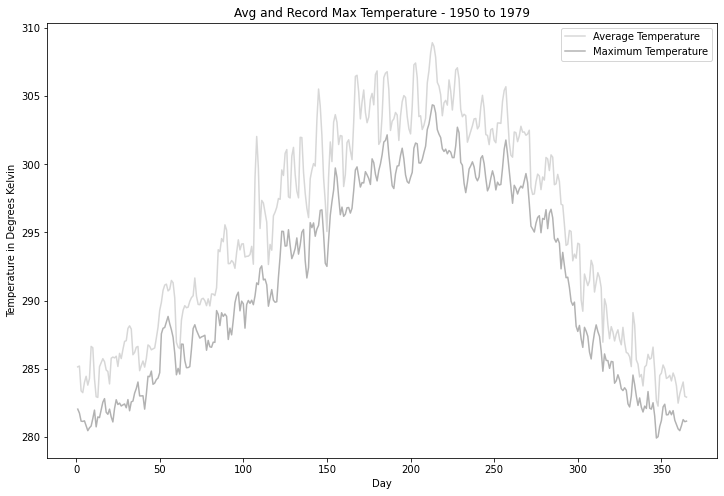

In [162]:
plot_avg_and_record_temperatures(avg_ds, latitude=47.2, longitude=238)

## Call the interactive function: Get 10-year Temp By Region

In [102]:
# cmip files - raw data from NASA site
name_prefix_1 = 'tasmax_day_GISS-E2-1-G_historical_r1i1p1f2_gn_'               # without the year at the end
name_prefix_2 = 'tasmax_day_GISS-E2-1-G_ssp245_r1i1p1f2_gn_'                   # without the year at the end

# url_prefix: remeber to update to tasmax or tasmin; provide without the filename
cmip_files_url_1 = 'https://data.nas.nasa.gov/viz/vizdata/armichae/gddp/GISS-E2-1-G/historical/r1i1p1f2/tasmax/'
cmip_files_url_2 = 'https://data.nas.nasa.gov/viz/vizdata/armichae/gddp/GISS-E2-1-G/ssp245/r1i1p1f2/tasmax/'

azure_url_prefix = 'https://nasanex30analysis.blob.core.windows.net/cmip6/10_year_temp'
sas_token = 'sp=racwdl&st=2021-10-07T16:00:56Z&se=2021-10-08T03:50:56Z&spr=https&sv=2020-08-04&sr=c&sig=yPR%2B5ARQ3lctMH3Vx24gc9YFTfJWzZpgu%2BMGBzeXotg%3D'

temp50yr_ds = Interactive_Get10yearTempFilesByRegionForRange(start_year=2020, end_year=2029, cmip=6, region_id=1, result_type='max'
                            , azure_url_prefix=azure_url_prefix, sas_token=sas_token
                            , cmip_files_urls=[cmip_files_url_1, cmip_files_url_2]
                            , cmip_file_name_prefixes=[name_prefix_1, name_prefix_2], urls_from_years=[1950, 2015]
                            , from_azure=False, save_back_in_azure=True, interactive=True, print_extra_msg=False)
temp50yr_ds

Get CMIP6 max temperature 10-year files for the range 2020 to 2029, for region: 1-North America


Do you want to continue? y/n y


16:01:54 UTC: Available locally? No. Checking in Azure...
16:01:54 UTC: Also not in Azure 10_year_max_temp_CMIP6__Region_1__2020_to_2029.nc, preparing...
16:01:54 UTC: Perparing 10-year file. Arranging for all the component (1-year) files
16:01:54 UTC: Component yearly file 1 of 10 : --- year 2020
16:04:57 UTC: Component yearly file 10 of 10 : --- year 2029
16:05:21 UTC: Save back in Azure = True. Upload file if not in Azure already
16:05:21 UTC: File 10_year_max_temp_CMIP6__Region_1__2020_to_2029.nc not in Azure already. Uploading now...
16:05:21 UTC: File 10_year_max_temp_CMIP6__Region_1__2020_to_2029.nc successfully uploaded.
Complete execution time | Interactive_Get10yearTempFilesByRegionForRange | (mins) 3.45


<xarray.Dataset>
Dimensions:  (time: 3650, lat: 71, lon: 161)
Coordinates:
  * time     (time) object 2020-01-01 12:00:00 ... 2029-12-31 12:00:00
  * lat      (lat) float64 14.12 15.12 16.12 17.12 ... 81.12 82.12 83.12 84.12
  * lon      (lon) float64 190.1 191.1 192.1 193.1 ... 347.1 348.1 349.1 350.1
Data variables:
    tasmax   (time, lat, lon) float32 ...
Attributes: (12/16)
    Dataset:            10-year max temperature CMIP6 region_id: 1
    About dataset:      A dataset with 10-year temparatures (tasmax), for the...
    Data variables:     tasmax
    Data description:   10-year max temperature for the specified region
    Range:              10 years
    Start year:         2020
    ...                 ...
    region_bottom_lat:  14
    region_left_lon:    190
    region_right_lon:   350
    region_img_url:     
    Years processed:    2030
    Store as:           10_year_max_temp_CMIP6__Region_1__2020_to_2029.nc

# Heatwave Identificiation

Identify heatwaves for:
 * the specified region
 * optionally, the specified'Get CMIP{} Heatwave identif area of interest
 * the specified duration (range of years - multiple of 10)
 * specify the threshold -- could be: 1) Fixed Temperature, 2) Fixed Value Above Average, or 3) Fixed Percentile Above Average
 * specify the number of consecutive days to consider as heatwave

In [172]:
# Identify heatwaves
def Identify_10_year_Heatwaves_By_Region(analysis_start_year, threshold
                            , based_on_averages=False, in_percentile=False
                            , n_continuous_days=3, cmip=6, model_name='historical', region_id=1
                            , averages_start_year=None, averages_end_year=None
                            , azure_url_heatwaves=None, sas_token=None
                            , azure_url_averages=None, azure_url_10_year_temp=None
                            , remove_source_files=True, area_of_interest=None
                            , interactive=False, print_extra_msg=False):
    """
    Makes available the heatwave identification data, for analysis of 10-year duration,
     for the specified region and optionally, for the specified area of interest
    If azure_url_heatwaves is provided then: 
      the file is first looked up in Azure and downloaded.
      else, the file is generated and then uploaded back in to Azure.
    Else - the file is generated.
    Assumes that the source data files (averages and 10-yr temp) are already available locally, or in Azure. 
      Please generate those separately if not already available.    
    
    The unit of temperature (Kelvin) is retained.
    Input Parameters:
    - analysis_start_year  : should be a multiple of 10 --- for example: 1950  OR  2000  OR  2050.
    - threshold            : a fixed temperature, or a value or pecentile above average that will be considered for heatwave
    - based_on_averages    : if True, the threshold is the difference above the average temperature. Else, actual temp in Kelvin
    - in_percentile        : True, a percentile above average. False, a fixed value above average. Evaluated only if based_on_averages=True. 
    - n_continuous_days    : number of continuous days of above threshold temperature to qualify as a heatwave.
    - cmip                 : integer number to specify cmip version (5 or 6 or other). Default is 6
    - model_name           : Specify the name of the model, for example 'ssp245'. This will become a part of the filename.
    - region_id            : integer ID of the region. See Regions class for available regions.
    - averages_start_year, averages_end_year: range of years to use for average temperatures
    - azure_url_heatwaves  : if provided, the heatwave identification results will be uploaded in Azure for reuse.
    - sas_token            : A sas token with 'read' permissions to the azure blob container. If saving back, then 'write' permission is required.  
    - azure_url_averages   : if averages file is to be downloded from azure. will be used only if not found locally.
    - azure_url_10_yr_temp : if 10-year temperature files are to be downloded from azure. will be used only if not found locally.
    - remove_source_files  : remove from local environment, after use, the source files (averages file and 10-year temperature files)
    - area_of_interest     : if provided, must be a dict with the keys: 'top_lat', 'bottom_lat', 'left_lon', 'right_lon'
    - print_extra_msg      : default is False. If True, will print out extra information during the processing.
    - interactive : If true, will prompt for user confirmation before executing. Set False to bypass user input.
    Returns: tuple of 1) xarray of the first 10-year file in the range and 2) xarray of the averages, if used, else None.
    """
    validations_passed = False
    result_type='max'
    ds_results = None
    filename = None
    averages_filename = None
    temp_10_year_filename = None
    sas_url = None
    
    top_lat = None
    bottom_lat = None
    left_lon = None
    right_lon = None
    
    validations_passed = Validations_for_Identify_10_year_Heatwaves_By_Region(analysis_start_year, threshold
                                                            , n_continuous_days, region_id, area_of_interest
                                                            , based_on_averages, averages_start_year, averages_end_year)
    
    analysis_end_year = analysis_start_year + 9
    reg = Regions().get_region_by_ID(region_id)
    
    if validations_passed:
        print_msg = 'Get Heatwave identification data\n ... for the range {} to {},'.format(analysis_start_year
                                                                                                   , analysis_end_year)
        print_msg += '\n ... for the region {}-{}'.format(region_id, reg['region_name'])
        print_msg += '\n ... for model {} of CMIP{}'.format(model_name, cmip)
        if area_of_interest is not None:
            print_msg += '\n ... area of interest: top_lat{}, bottom_lat{}, left_lon, right_lon'.format(area_of_interest.get('top_lat'),
                                                                                                    area_of_interest.get('bottom_lat'),
                                                                                                    area_of_interest.get('left_lon'),
                                                                                                    area_of_interest.get('right_lon'))
        if based_on_averages:
            print_msg += '\n ... for {}{} above average from the years {} to {}'.format(threshold, '%' if in_percentile else ' Kelvin'
                                                                           , averages_start_year, averages_end_year)
        else:
            print_msg += '\n ... for temperature above {} Kelvin'.format(threshold)
        print_msg += '\n ... when observed for {} continuous days\n'.format(n_continuous_days)
        
        print(print_msg)
        
        if interactive:
            ans = input('Do you want to continue? y/n').lower()
        else:
            ans = 'y'
        
        if not ans == 'y':
            print("Response: {}.\n Not 'y', stopping execution.".format(ans))        
            return None
        
        start_time = time.time()        # prepare to time the operation
        
        heatwaves_filename = '10_year_Heatwaves_Data_CMIP{}_{}__Region_{}__{}_to_{}.nc'.format(cmip, model_name
                                                                               , region_id, analysis_start_year, analysis_end_year)                
        

       # get 10 year temp file
#         temp_10_year_filename = '10_year_{}_temp_CMIP{}_{}__Region_{}__{}_to_{}.nc'.format(result_type, cmip, model_name
#                                                                                , region_id, analysis_start_year, analysis_end_year)                
        temp_10_year_filename = '10_year_{}_temp_CMIP{}__Region_{}__{}_to_{}.nc'.format(result_type, cmip
                                                                               , region_id, analysis_start_year, analysis_end_year)                
        print('{} UTC: Working with 10_year temperature filename: {}'.format(datetime.now().strftime("%H:%M:%S"), temp_10_year_filename))
        filename = temp_10_year_filename
        local = os.path.exists(filename)    # first, check if available locally
        print("{} UTC: Available locally? {}".format(datetime.now().strftime("%H:%M:%S"), 'Yes' if local else 'No. Checking in Azure...'))
        if not local:            
            if azure_url_10_year_temp is not None: 
                sas_url = create_sas_url(azure_url_10_year_temp, sas_token, filename)
                if is_file_in_Azure(sas_url):
                    print("{} UTC: Available in Azure {}, downloading...".format(datetime.now().strftime("%H:%M:%S"), filename))
                    download_file(sas_url, filename, overwrite_local_file=True, from_azure=True)
                    print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))                    
                else:
                    print("{} UTC: Also not in Azure {}. Error!".format(datetime.now().strftime("%H:%M:%S"), filename))
                    raise ValueError('Required file {} not found in the local environment or in Azure.'.format(filename))
            else:
                raise ValueError('Required file {} not found in the local environment. Url not provided to check in Azure.'.format(filename))
        
        ds_10_year_temp = xr.open_dataset(filename)
        
        
        # Determine applicable area of interest 
        if area_of_interest is not None:
            top_lat = area_of_interest.get('top_lat')
            bottom_lat = area_of_interest.get('bottom_lat')
            left_lon = area_of_interest.get('left_lon')
            right_lon = area_of_interest.get('right_lon')
            # and take subset
            ds_10_year_temp = region_subset(ds_10_year_temp, top_lat, bottom_lat, left_lon, right_lon)
        else:
            top_lat = reg['top_lat']
            bottom_lat = reg['bottom_lat']
            left_lon = reg['left_lon']
            right_lon = reg['right_lon']
        
        
        if based_on_averages:
            # get averages file
            n_years = (averages_end_year - averages_start_year) + 1
            averages_filename = 'Avg_temp_{}_CMIP{}__{}_yrs__{}_to_{}.nc'.format(result_type, cmip, n_years, averages_start_year, averages_end_year) 
            print('{} UTC: Working with Averages filename: {}'.format(datetime.now().strftime("%H:%M:%S"), averages_filename))
            filename = averages_filename
            local = os.path.exists(filename)    # first, check if available locally
            print("{} UTC: Available locally? {}".format(datetime.now().strftime("%H:%M:%S"), 'Yes' if local else 'No. Checking in Azure...'))
            if not local:            
                if azure_url_10_year_temp is not None: 
                    sas_url = create_sas_url(azure_url_10_year_temp, sas_token, filename)
                    if is_file_in_Azure(sas_url):
                        print("{} UTC: Available in Azure {}, downloading...".format(datetime.now().strftime("%H:%M:%S"), filename))
                        download_file(sas_url, filename, overwrite_local_file=True, from_azure=True)
                        print("{} UTC: Download complete".format(datetime.now().strftime("%H:%M:%S")))                    
                    else:
                        print("{} UTC: Also not in Azure {}. Error!".format(datetime.now().strftime("%H:%M:%S"), filename))
                        raise ValueError('Required file {} not found in the local environment or in Azure.'.format(filename))
                else:
                    raise ValueError('Required file {} not found in the local environment. Url not provided to check in Azure.'.format(filename))

            ds_averages = xr.open_dataset(filename)
            # subset of averages
            ds_averages = region_subset(ds_averages, top_lat, bottom_lat, left_lon, right_lon)
            
            ds_10_year_temp = ds_10_year_temp.assign(above_threshold=lambda x: x.tasmax + 0)   # first create the new column with the original temperature
            for i in range(10):
                days_start = i * 365
                days_end = days_start + 365
                if in_percentile:
                    ds_10_year_temp.above_threshold[days_start:days_end,:,:] = \
                        ds_10_year_temp.above_threshold[days_start:days_end,:,:] - (ds_averages.tasmaxavg.values * (1 + (threshold/100)))
                else:
                    ds_10_year_temp.above_threshold[days_start:days_end,:,:] = \
                        ds_10_year_temp.above_threshold[days_start:days_end,:,:] - (ds_averages.tasmaxavg.values + threshold)
            
#             ds_10_year_temp = ds_10_year_temp.assign(tasmaxavg= ds_averages.tasmaxavg.values)
    
        else:       # based_on_averages=False
            ds_10_year_temp = ds_10_year_temp.assign(above_threshold=lambda x: x.tasmax - threshold)
            ds_averages = None
        
        # determine heatwave Y/N, using rolling windows of n_continuous_days
        rolling = ds_10_year_temp.above_threshold.rolling(time=n_continuous_days)
        rolling.construct("window_dim")
        arr_win_status = rolling.reduce(window_gte_threshold)
        arr_hw = np.zeros(np.shape(ds_10_year_temp.tasmax))
        n_idx = n_continuous_days - 1
        for i in range(n_idx):
            arr_hw[i:i-n_idx,:,:] =   xr.ufuncs.logical_or(arr_hw[i:i-n_idx,:,:], arr_win_status[n_idx:,:,:])
        arr_hw[n_idx:,:,:] =   xr.ufuncs.logical_or(arr_hw[n_idx:,:,:], arr_win_status[n_idx:,:,:])
        
        ds_10_year_temp = ds_10_year_temp.assign(heatwave_yn = (ds_10_year_temp.dims, arr_hw))
        
        ds_results = ds_10_year_temp
        
        # update attributes 
        ds_results.attrs['Dataset'] = '10-year Heatwave Data CMIP{} {} region_id: {}'.format(cmip, model_name, region_id)
        ds_results.attrs['About dataset'] = 'A dataset with 10-year Heatwave Data, for CMIP{} model: {}, for the region {}-{}'.format(cmip, model_name
                                                                                                                  , region_id
                                                                                                            , reg.get('region_name'))
        ds_results.attrs['Data variables'] = 'tasmax, above_threshold, heatwave_yn'
        ds_results.attrs['Data description'] = 'maximum temperature; difference from theshold; 1 or 0 for heatwave yes or no'
        ds_results.attrs['Years processed'] = 1
        ds_results.attrs['Store as'] = heatwaves_filename
                    
        
        # save and if azure_url_heatwaves is provided, then upload to azure
        SaveResult(ds_results, azure_url_prefix = azure_url_heatwaves, sas_token=sas_token, local_copy=True)
        
        print('{} UTC: Saved locally: 10-year Heatwaves file: {}'.format(datetime.now().strftime("%H:%M:%S"), heatwaves_filename))
        if azure_url_heatwaves is not None:
            print('{} UTC: Also uploaded to Azure storage'.format(datetime.now().strftime("%H:%M:%S"), heatwaves_filename))
            

        # print out the time it took
        execution_time = (time.time() - start_time)
        print("Complete execution time | Identify_10_year_Heatwaves_By_Region | (mins) {:0.2f}".format(execution_time/60.0))
        
        return ds_results, ds_averages
    

## Call to get Heatwave Identification Data

In [173]:
azure_url_heatwaves = 'https://nasanex30analysis.blob.core.windows.net/cmip6/heatwaves'
azure_url_averages = 'https://nasanex30analysis.blob.core.windows.net/cmip6/averages'
azure_url_10_year_temp = 'https://nasanex30analysis.blob.core.windows.net/cmip6/10_year_temp'
sas_token = 'sp=racwdl&st=2021-10-09T14:20:53Z&se=2021-10-10T03:20:53Z&spr=https&sv=2020-08-04&sr=c&sig=brPsircIZalTBoq3IrHCh47%2BNeCAqYZDbQsGCUoqPcY%3D'
model_name = 'ssp245'

hw_ds, avg_ds = Identify_10_year_Heatwaves_By_Region(analysis_start_year=2020, threshold=1
                            , based_on_averages=True, in_percentile=False
                            , n_continuous_days=3, cmip=6, model_name=model_name, region_id=1
                            , averages_start_year=1950, averages_end_year=1979
                            , azure_url_heatwaves=azure_url_heatwaves, sas_token=sas_token
                            , azure_url_averages=azure_url_averages, azure_url_10_year_temp=azure_url_10_year_temp
                            , remove_source_files=False, area_of_interest=None
                            , interactive=True, print_extra_msg=True)
hw_ds

Get Heatwave identification data
 ... for the range 2020 to 2029,
 ... for the region 1-North America
 ... for model ssp245 of CMIP6
 ... for 1 Kelvin above average from the years 1950 to 1979
 ... when observed for 3 continuous days



Do you want to continue? y/n y


02:10:33 UTC: Working with 10_year temperature filename: 10_year_max_temp_CMIP6__Region_1__2020_to_2029.nc
02:10:33 UTC: Available locally? Yes
02:10:33 UTC: Working with Averages filename: Avg_temp_max_CMIP6__30_yrs__1950_to_1979.nc
02:10:33 UTC: Available locally? Yes
Complete execution time | SaveResult | (mins) 0.13
Complete execution time | Interactive_Get10yearTempFilesByRegionForRange | (mins) 4.68


<xarray.Dataset>
Dimensions:          (time: 3650, lat: 71, lon: 161)
Coordinates:
  * time             (time) object 2020-01-01 12:00:00 ... 2029-12-31 12:00:00
  * lat              (lat) float64 14.12 15.12 16.12 17.12 ... 82.12 83.12 84.12
  * lon              (lon) float64 190.1 191.1 192.1 193.1 ... 348.1 349.1 350.1
Data variables:
    tasmax           (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    above_threshold  (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    heatwave_yn      (time, lat, lon) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes: (12/16)
    Dataset:            10-year Heatwave Data CMIP6 ssp245 region_id: 1
    About dataset:      A dataset with 10-year Heatwave Data, for CMIP6 model...
    Data variables:     tasmax, above_threshold, heatwave_yn
    Data description:   maximum temperature; difference from theshold; 1 or 0...
    Range:              10 years
    Start year:         2020
    ...                 ...
    region_bottom_lat:  14
    region_left_lon:    190
    region_right_lon:   350
    region_img_url:     
    Years processed:    1
    Store as:           10_year_Heatwaves_Data_CMIP6_ssp245__Region_1__2020_t...

### Verify results

In [ ]:
start_idx = 345
end_idx = 355
print('above_threshold', np.round(hw_ds.above_threshold[start_idx:end_idx,59,119].values,2))
# print('win_status', win_status[start_idx:end_idx,59,119].values)
print('heatwave_yn', hw_ds.heatwave_yn[start_idx:end_idx,59,119].values)

above_threshold [ 9.38  3.6   2.27  1.05  1.99 -4.09 -2.97 -2.77 -4.84 -7.43]
heatwave_yn [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]


In [95]:
hw_ds.isel(hw_ds.above_threshold.isin([-1,-5]).argmax(...))

<xarray.Dataset>
Dimensions:          ()
Coordinates:
    time             object 2020-02-01 12:00:00
    lat              float64 51.12
    lon              float64 273.1
Data variables:
    tasmax           float32 265.0
    above_threshold  float32 -1.0
    heatwave_yn      bool False
Attributes: (12/16)
    Dataset:            10-year max temperature CMIP6 region_id: 1
    About dataset:      A dataset with 10-year temparatures (tasmax), for the...
    Data variables:     tasmax
    Data description:   10-year max temperature for the specified region
    Range:              10 years
    Start year:         2020
    ...                 ...
    region_bottom_lat:  14
    region_left_lon:    190
    region_right_lon:   350
    region_img_url:     
    Years processed:    2030
    Store as:           10_year_max_temp_CMIP6__Region_1__2020_to_2029.nc

In [54]:
show_results_for_lat_lon(hw_ds, 47, 278, 2020, 5, 1)  # dataset with dimension time 'year-month-day'
# show_results_for_lat_lon(hw_ds, 47, 278, 0, 0, 1)     # dataset with dimension 'day' 1 to 365

Coordinates:
  * time     (time) object 2020-05-01 12:00:00
  * lat      (lat) float64 47.12
  * lon      (lon) float64 278.1
tasmax
[[[292.52963]]]
above_threshold
[[[-3.880371]]]
